# Forecasting Wikipedia Pageviews - Figma (Software)

This project aims to forecast the daily Wikipedia pageviews of the "Figma (software)" article from 2022 onward using time series analysis and Facebook Prophet. The dataset displays weekly seasonality, a mild upward trend, and occasional anomalies. Our approach involves:

* Visualising the data
* Handling anomalies
* Fitting a time series forecasting model
* Making and visualising predictions

## Data Inspection Part 1 - Import Libraries
We begin by importing the necessary Python libraries for data handling and plotting. 

* **Pandas**: for efficient data manipulation and date handling
* **Matplotlib**: for basic but clear visualisations

In [1]:
# import the necessary libraries to understand the data
import pandas as pd
import matplotlib.pyplot as plt

## Data Inspection Part 2 - Load and Visualise the Data

We load the data, ensure it is sorted by date, and visualise it to observe trends, seasonality, and any irregularities.

<Axes: title={'center': 'Figma Wikipedia Pageviews Over Time'}>

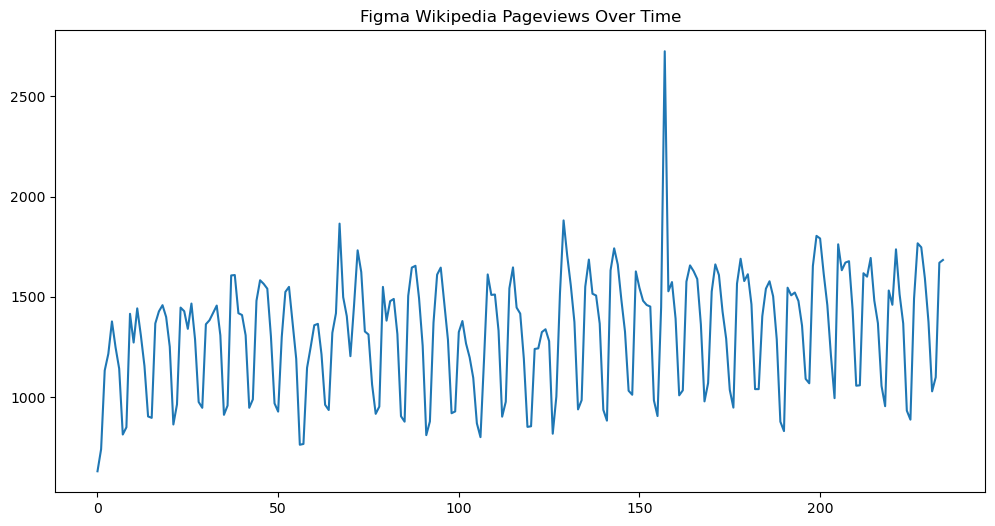

In [2]:
# Load the data and plot it to have a quick look 
df = pd.read_csv('pageviews-20220101-20220823.csv', parse_dates=["Date"])
df = df.sort_values('Date')
df["Figma (software)"].plot(figsize=(12, 6), title="Figma Wikipedia Pageviews Over Time")

## Data Cleaning Part 1 - Handle Anomalies Using STL Decomposition

We use **STL (Seasonal-Trend Decomposition using Loess)** from `statsmodels` to break the time series into trend, seasonality, and residual (noise). This helps us identify outliers in the residual component. Since **weekly seasonality** is observed, we will use a period of 7 days.

We use STL as it can decompose the time series into trend, seasonality, and residuals, helping us detect anomalies. 

In [3]:
#Handle anomalies using STL decomposition

from statsmodels.tsa.seasonal import STL

stl = STL(df['Figma (software)'], period=7) #7 because we see a seasonal change on a weekly basis 
res = stl.fit()

# create extra columns in the dataset for easier inspection
df['trend'] = res.trend
df['seasonal'] = res.seasonal 
df['resid'] = res.resid

## Data Cleaning Part 2 - Detect and Handle Outliers

We will detect anomalies in the residuals using Z-scores. Values where the Z-score exceeds 3 (a standard practice for outlier detection) are replaced with NaNs, then interpolated to fill in a smoothed value.

We will use **NumPy** to compute Z-scores for outlier detection.

In [4]:
# Replace outliers in the original data using Z-score on residuals

import numpy as np

z = (df['resid'] - df['resid'].mean()) / df['resid'].std()
df['Figma (software)_clean'] = df['Figma (software)'].where(z.abs() < 3, np.nan)
df['Figma (software)_clean'] = df['Figma (software)_clean'].interpolate()

## Data Cleaning Part 3 - Prepare the Data for Prophet

We will be using **Prophet** (developed by Facebook/Meta) to create the model for predictions for the following reasons:

* It models **trend and seasonality explicitly**, which is important here (weekly seasonality and upward trend)
* It handles **missing or irregularly spaced data** without manual imputation
* It is designed for **business-style time series** like website traffic, which often has consistent seasonal cycles and sudden events
* It requires **minimal hyperparameter tuning**, making it accessible for real-world forecasting without deep statistical expertise

While other options (like ARIMA or LSTM) exist, they often require:

* More data preprocessing
* Deep knowledge of model tuning
* More assumptions about stationarity or input format

Prophet balances power and ease-of-use, so will be the choice of library for this task.

## Preparing data for Prophet 
Prophet requires a specific format: `ds` for the date and `y` for the target variable, so we will prepare the cleaned data accordingly.

In [5]:
# Forecasting with Facebook Prophet

from prophet import Prophet
prophet_df = df[['Date', 'Figma (software)_clean']].rename(columns={'Date': 'ds', 'Figma (software)_clean': 'y'})

## Build and Fit the Prophet Model

We instantiate the Prophet model with **weekly seasonality** (as observed earlier) and fit it to our cleaned data.

In [6]:
# Build and fit Prophet model
model = Prophet(weekly_seasonality=True, daily_seasonality=False)
model.fit(prophet_df)

12:41:01 - cmdstanpy - INFO - Chain [1] start processing
12:41:01 - cmdstanpy - INFO - Chain [1] done processing


## Making Predictions

We generate forecasts 365 days into the future — roughly until mid-next year. Prophet will continue the trend and weekly pattern it learned from the training data.

In [7]:
# Making predictions
future = model.make_future_dataframe(periods=365)
forecast = model.predict(future)

## Visualise Forecast Results

### 1. Overall Forecast (`model.plot(forecast)`):
This plot shows:
- **Predicted future values** (`yhat`)
- **Actual past values (black dots)**
- **Uncertainty intervals** (`yhat_upper`, `yhat_lower`) that indicate confidence

This helps us assess how well the model captures the original signal and what it expects in the future.

### 2. Decomposed Forecast Components (`model.plot_components(forecast)`):
Prophet automatically breaks the forecast into:
- **Trend**: The long-term direction (e.g., increasing interest over time)
- **Seasonality**: Regular, repeatable patterns (e.g., weekly cycles in pageviews)

### Why decomposing forecast components?

- It lets us **interpret** the model's logic — how much of the prediction is due to seasonality vs. trend
- We can **spot model errors** — for instance, if it falsely assumes a weekend drop every week when traffic patterns have changed
- It helps with **business storytelling** — ie., the traffic is growing slowly overall, but it peaks on Wednesdays consistently.

In short: visualising components gives us both **transparency and interpretability**, two things traditional time series models often lack.

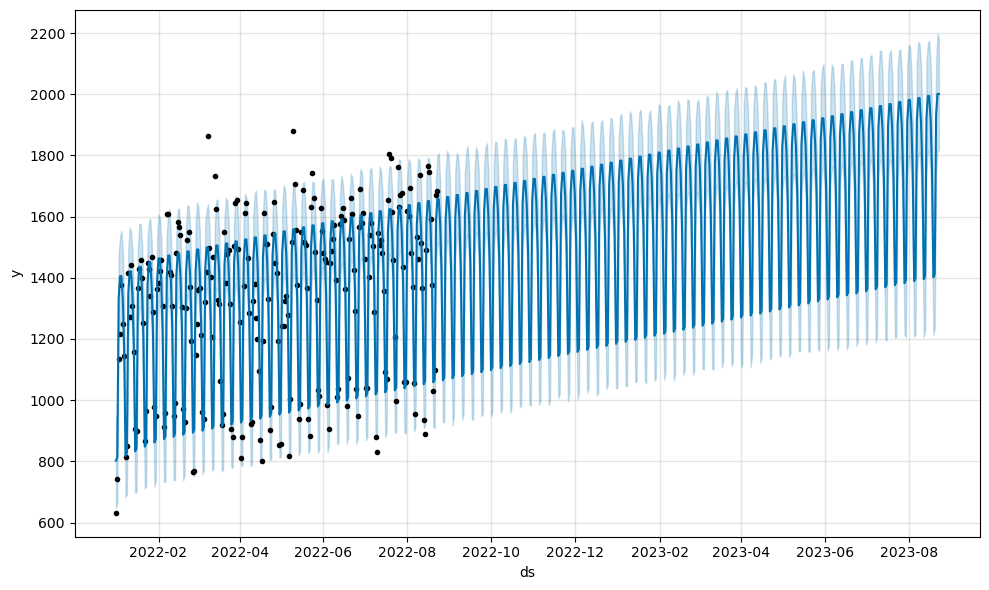

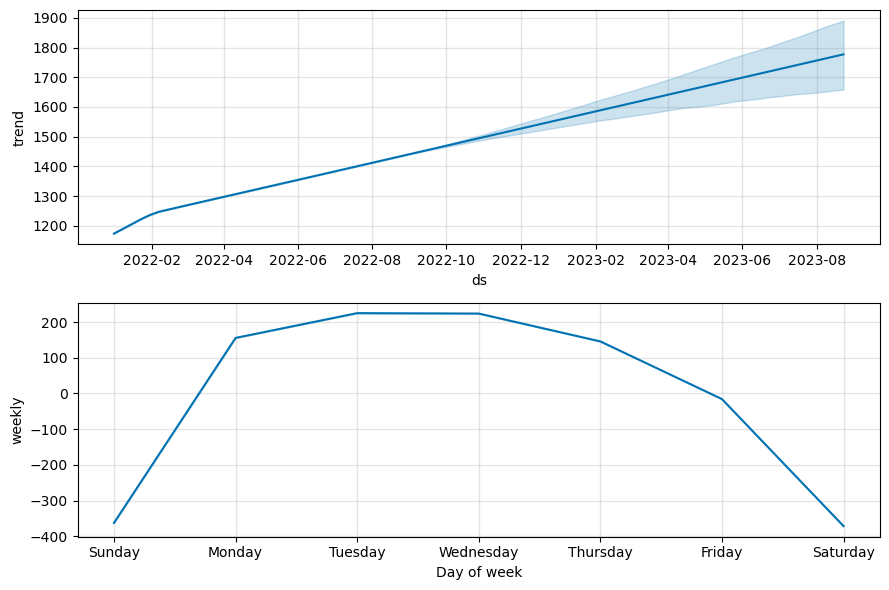

In [8]:
# Plot forecast
model.plot(forecast);

# Plot trend and seasonality components
model.plot_components(forecast);

## Analysis

1. The dataset exhibits a **mild upward trend** and clear **weekly seasonality**, which we confirmed visually and via STL decomposition.
2. **STL** was used to break the series into trend/seasonal/residual components, allowing us to **detect and smooth anomalies**. This preprocessing step helped ensure our model focused on meaningful patterns rather than short-term noise.
3. We chose **Facebook Prophet** for its ability to:
   
   * Handle seasonality and trend explicitly
   * Manage missing data and outliers
   * Offer intuitive, interpretable forecasts

5. The **overall forecast plot** shows a steady increase in interest for the Figma (software) page, with regular weekly ups and downs.
6. The **component plots** help us see how much of the forecast is due to:
   
   * Long-term **trend growth**
   * Predictable **weekly traffic patterns**
     
8. This transparency is essential for trust in the model and helps guide decisions (e.g. planning content drops or marketing).

## Conclusion:
The model forecasts a continued rise in traffic to the Figma page, with expected weekly fluctuations. The process used here — combining STL for anomaly handling and Prophet for interpretable forecasting — is robust, scalable, and suitable for similar time series forecasting problems in real-world business settings.